In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
import pandas as pd
from astropy import coordinates
from astropy import units as u
from skipper import observe, planner

In [5]:
import sys
sys.path.append('../scripts/')

In [6]:
import sigjson_f2022b
import our_pointings

In [7]:
obsdates = sigjson_f2022b.obsdates

obskeys = [ f'{x[0]:02d}-{x[1]:02d}-{x[2]:02d}' for x in obsdates[:,:3]]

def wrapRA(ra, wrap_point=180.):
    mask = ra >= wrap_point
    wrapped_ra = ra.copy()
    wrapped_ra[mask] -= 360.
    return wrapped_ra

In [8]:
tele_fname = '/Users/kadofong/Downloads/tele20220927.csv'
copilot_fname = '/Users/kadofong/Downloads/db_merian.fits'

In [36]:
obsdates = sigjson_f2022b.obsdates
obsfilters = sigjson_f2022b.obsfilters

oiii_nights = obsdates[obsfilters == 'N540', :-1]
halpha_nights = obsdates[obsfilters=='N708',:-1]

hcat, ocat = our_pointings.load_fallfields ()

coo_o = observe.CopilotOutput ( copilot_fname, ocat, skySB_0=22.1 )
coo_h = observe.CopilotOutput ( copilot_fname, hcat, skySB_0=21. )

# OIII observations

In [15]:
night = oiii_nights[3]

dt = f'{night[0]}{night[1]:02d}{night[2]:02d}' #20220920
if not os.path.exists ( f'../json/{dt}'):
    os.mkdir(f'../json/{dt}')
    
stdout = sys.stdout
with open(f'../json/{dt}/output.log','w') as sys.stdout:
    is_queued = sigjson_f2022b.plan_tomorrow( night[2], night[1], night[0], tele_fname, 
                                             copilot_fname, mfilt='N540', is_queued=None, 
                                             pad_last_hour=True, maxairmass=1.8, save=True, verbose=True)
sys.stdout = stdout

In [16]:
to_obs = is_queued.loc[~is_queued['qstamp'].isna()]

In [45]:
tele = pd.read_csv(tele_fname, index_col=0)
tele_dt = pd.to_datetime(tele['date'])
lastnight = pd._libs.tslibs.timestamps.Timestamp(year=night[0], month=night[1], day=night[2]-1, tz='UTC')
observed_last_night = tele.loc[tele_dt.apply(lambda x: x > lastnight),'object']
lastnightobjects = np.in1d(ocat['object'], observed_last_night)

In [ ]:
reobs = coo_o.flag_for_reobservation ()

,object,comment,filter,seqtot,seqnum,seqid,expType,proposer,program,RA,propid,dec,expTime,count,wait
VVDS_J223622.10+005603.00_N540,VVDSearly_J223622.10+005603.00_N540,--,N540,128,1,S2021B,object,Leauthaud,Merian,339.092091,2020B-0288,0.934167,900.0,1,False
VVDS_J223731.99+010050.17_N540,VVDSearly_J223731.99+010050.17_N540,--,N540,128,2,S2021B,object,Leauthaud,Merian,339.383325,2020B-0288,1.013937,900.0,1,False
VVDS_J223842.58+010345.97_N540,VVDSearly_J223842.58+010345.97_N540,--,N540,128,3,S2021B,object,Leauthaud,Merian,339.677450,2020B-0288,1.062771,900.0,1,False
VVDS_J223953.17+010642.32_N540,VVDSearly_J223953.17+010642.32_N540,--,N540,128,4,S2021B,object,Leauthaud,Merian,339.971568,2020B-0288,1.111756,900.0,1,False
VVDS_J230552.64+010311.66_N540,VVDSlate_J230552.64+010311.66_N540,--,N540,128,34,S2021B,object,Leauthaud,Merian,346.469370,2020B-0288,1.053240,900.0,1,False
VVDS_J230703.26+010611.51_N540,VVDSlate_J230703.26+010611.51_N540,--,N540,128,35,S2021B,object,Leauthaud,Merian,346.763602,2020B-0288,1.103200,900.0,1,False
VVDS_J224058.75+023139.31_N540,VVDSearly_J224058.75+023139.31_N540,--,N540,128,70,S2021B,object,Leauthaud,Merian,340.244803,2020B-0288,2.527587,900.0,1,False
VVDS_J223620.21+023717.00_N540,VVDSearly_J223620.21+023717.00_N540,--,N540,128,120,S2021B,object,Leauthaud,Merian,339.084246,2020B-0288,2.621389,900.0,1,False
XMM_J022645.71+364125.69_N540,XMM_J022645.71+364125.69_N540,--,N540,104,7,S2021B,object,Leauthaud,Merian,36.690470,2020B-0288,0.908807,900.0,1,False


In [53]:
np.in1d(reobs,ocat.loc[lastnightobjects, 'object'])

array([False,  True,  True,  True,  True,  True,  True,  True,  True])

/var/folders/fs/f3k7bp2n3k1bldhn58thddt40000gn/T/ipykernel_8937/1886687365.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_obs['odate'] = to_obs.apply(lambda x: x['qstamp'].split("_")[0], axis=1)


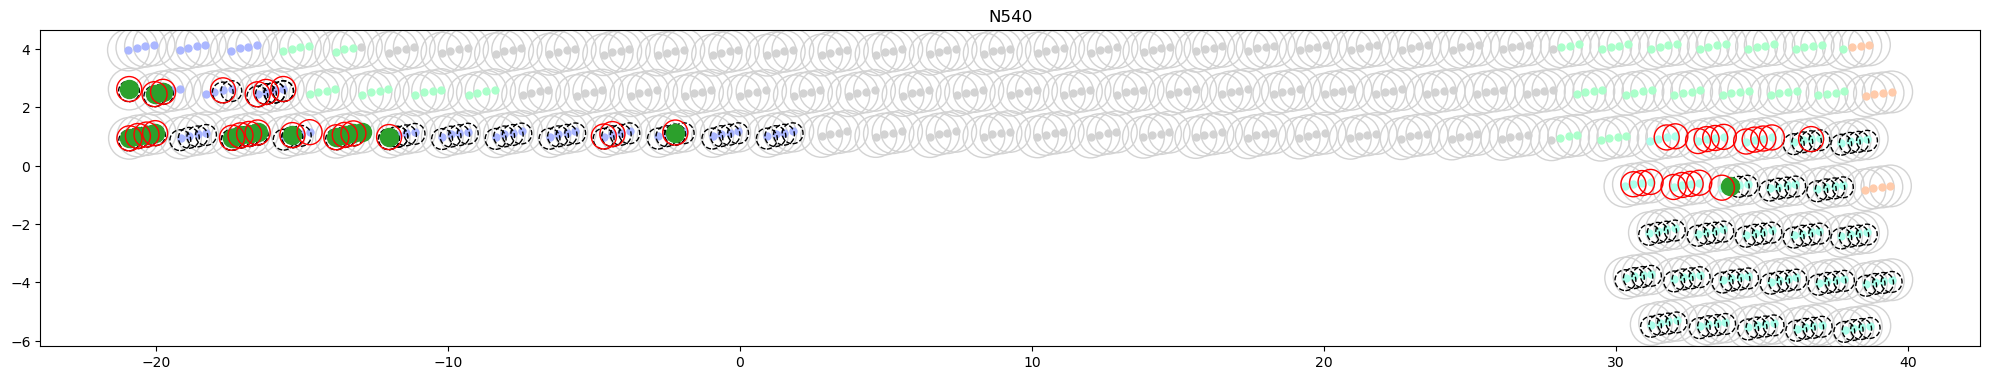

In [22]:
fields = ocat['object'].str.extract(r'(.*?(?=_))')[0]

fig = plt.figure(figsize=(20,4))
ax = plt.subplot(111)
ax.set_aspect('equal')

cc_l = ['#abb7ff','#abffeb','#abffcb','#feffab','#ffcbab','lightgrey']
#['tab:red','tab:blue','tab:green','tab:purple','grey','tab:orange']
#['#abb7ff','#abffeb','#abffcb','#feffab','#ffcbab','lightgrey']

plt.scatter ( wrapRA(hcat['RA']), hcat['dec'], facecolor='None', edgecolor='lightgrey', s=30**2)
for field in fields.unique():
    cat = ocat.loc[fields==field]
    idx = sigjson_f2022b._field_priorities[field]
    plt.scatter ( wrapRA(cat['RA']), cat['dec'], c=cc_l[idx], s=5**2)
    
plt.scatter ( wrapRA(coo_o.merian_sidecar['racenter']), coo_o.merian_sidecar['deccenter'], 
             facecolor='None', edgecolor='k', s=15**2, ls='--' )
plt.scatter ( wrapRA( ocat.loc[lastnightobjects, 'RA'] ), wrapRA(ocat.loc[lastnightobjects, 'dec']), facecolor='tab:green', s=13**2 )

# \\ show pointings that need reobservation
needs_reobservation = ocat.loc[np.in1d(ocat['object'],reobs)]
plt.scatter ( wrapRA ( needs_reobservation['RA'] ), wrapRA( needs_reobservation['dec'] ), edgecolor='tab:blue', facecolor='None', s=

to_obs['odate'] = to_obs.apply(lambda x: x['qstamp'].split("_")[0], axis=1)

#grps = to_obs.groupby('odate')
#for idx,(name,grp) in enumerate(grps):
#    cc = plt.cm.Dark2(idx/grps.ngroups)
#    plt.scatter ( wrapRA(ocat.reindex(grp.index)['RA']), ocat.reindex(grp.index)['dec'], facecolor='None', edgecolor=cc, s=18**2, lw=1 )
#    print(grp.shape[0])
plt.scatter ( wrapRA(ocat.reindex(to_obs.index)['RA']), ocat.reindex(to_obs.index)['dec'], 
             facecolor='None', edgecolor='r', s=18**2, lw=1 )

#plt.axvline(38.)
plt.title('N540')
plt.tight_layout ()
#plt.savefig('/Users/kadofong/Downloads/N540_2022Bprediction.png')

# Copy [OIII] observation to H$\alpha$

In [9]:
halpha_nights

array([[2022,    9,   21,    2],
       [2022,    9,   23,    2],
       [2022,    9,   28,    0],
       [2022,    9,   29,    0],
       [2022,    9,   30,    0],
       [2022,   10,    4,    2]])

In [13]:
night = halpha_nights[2]

year = night[0]
month = night[1]
day = night[2]
lastobs_day = day -1

In [14]:
tele = pd.read_csv(tele_fname, index_col=0)
tele_dt = pd.to_datetime(tele['date'])
lastnight = pd._libs.tslibs.timestamps.Timestamp(year=year, month=month, day=lastobs_day, tz='UTC')

In [15]:
import re

def find_queue_today ( year, month, day, hack_cat, dd=1 ):
    '''
    Only allow us to queue observations from yesterday
    '''
    # \\ get observed pointings from the last time we observed
    lastnight = pd._libs.tslibs.timestamps.Timestamp(year=year, month=month, day=day-dd, tz='UTC')
    observed_last_night = tele.loc[tele_dt.apply(lambda x: x > lastnight),'object'] # XXX check if this is with field names or not
    analogous = hack_cat.reindex(observed_last_night ) 
    # \\ add in XMM non-analogs
    nonanalogous = hack_cat['qstamp'] == 'NONE'
    in_queue_today = analogous|nonanalogous
    return in_queue_today


In [16]:
observed_last_night = tele.loc[tele_dt.apply(lambda x: x > lastnight),'object']

In [18]:
# \\ need to match OIII planned observations to Halpha catalog

# \\ load N708 & N540 pointings
halpha_locations = coordinates.SkyCoord( hcat['RA'], hcat['dec'], unit=('deg','deg'))
#planned_oiii_obscoords = coordinates.SkyCoord( ocat.reindex(is_queued.loc[is_queued['is_queued']].index)['RA'], 
#                                               ocat.reindex(is_queued.loc[is_queued['is_queued']].index)['dec'], 
#                                               unit=('deg','deg'))
lastnightobjects = np.in1d(ocat['object'], observed_last_night)
oiii_FLO = coordinates.SkyCoord ( ocat.loc[lastnightobjects, 'RA'],
                                  ocat.loc[lastnightobjects, 'dec'],
                                  unit=('deg','deg') )

# \\ match via coordinates
matchids, sep, _ = oiii_FLO.match_to_catalog_sky ( halpha_locations )
matches = sep < 0.05*u.arcsec

# \\ aggregate all Halpha pointings that are in the OIII queue
nominally_new_inN708 = hcat.index[matchids]
#nominally_new_inN708['qstamp'] = to_obs['qstamp']
# \\ identify which pointings have already been observed in Halpha
already_observed_inN708 = np.in1d(hcat.reindex(nominally_new_inN708)['object'], coo_h.merian_sidecar['object'])
truly_new_inN708 = hcat.reindex(nominally_new_inN708).loc[~already_observed_inN708].copy()
#truly_new_inN708['qstamp'] = is_queued.query('is_queued').loc[~already_observed_inN708, 'qstamp'].values
#truly_new_inN708['object'] = truly_new_inN708['object'].apply ( lambda x: 'OIIIanalog_' + x.split('_')[1] )

# \\ the pointings that "can" be observed should be the truly new in queue
# \\ PLUS XMM pointings, but XMM should be downgraded
hcat_fields = hcat['object'].str.extract(r'(.*?(?=_))')[0]
is_xmm = hcat_fields == 'XMM'
#is_xv = hcat_fields == 'btwnXV'
xmmtogo = hcat.loc[is_xmm].copy ()
xmmtogo['qstamp'] = 'NONE'

hack_cat = pd.concat([truly_new_inN708, xmmtogo])
# \\ remove pointings that are both in XMM and scheduled for 
# \\ OIII observations
hack_cat = hack_cat.loc[~hack_cat.index.duplicated( keep='first')]
hack_cat['qstamp'] = hack_cat['qstamp'].replace(np.NaN, 'NONE')

In [19]:
#is_queued = pd.DataFrame(index=hcat.index, columns=['is_queued','qstamp','airmass'])
halpha_priorities = {'VVDSearly':0, 'VVDSlate':0, 'VVDS':0, 'XMM':100, 'btwnXV':2, 'XMMhigh':4, 'newRAbtwnXV':5}


todaycat = hack_cat

#isqueuedtoday = pd.DataFrame(index=todaycat.index, columns=['is_queued','qstamp','airmass'])      
#isqueuedtoday['is_queued'] = False

is_queued_halpha = sigjson_f2022b.plan_tomorrow( day, month, year, 
                                         tele_fname, copilot_fname, mfilt='N708', 
                                         pointings=todaycat,
                                         is_queued=None, 
                                         priorities = halpha_priorities,
                                         pad_last_hour=False, maxairmass=1.7, save=False, verbose=True)
#inq.extend(is_queued_halpha.index[~is_queued_halpha['qstamp'].isna()])

DAY:       28
MONTH:     9
YEAR:      2022
TELEFILE:  /Users/kadofong/Downloads/tele20220927.csv
COPILOT:   /Users/kadofong/Downloads/db_merian.fits
.         *          
    *    .        *        .   .     .
      ____            .    {\*/}           .  *     .
  . .___\\`.  .         *   >!<      . 
    |   .. |     .         (/^\)   
    |------|          *    '   '      *
    |    _ |                      *
  _ '__ |_|'_	        SKIPPER
/       //   \        [MERIAN OBSPLANNER]
       //      \_ _    
       \\            \_ .  _  .
_______________ _  _ __ _  __      _  .   .

[verify_synchronicity] last exposure in logs is 1136386, taken at 2022-09-28 09:08:06.644990+00:00
On 2022/9/28, we are observing None in N708
We are observing the full of the night
0 pointings in this catalog need reobservation!


[predict] night slot: Full night
obsStart: 2022/09/28 08:45 PM Santiago
          2022/09/28 07:45 PM ET
          2022/09/28 04:45 PM PT
          2022/09/28 11:45 PM UTC
obsEnd:   2022/09/29 06:22 AM Santiago
          2022/09/29 05:22 AM ET
          2022/09/29 02:22 AM PT
          2022/09/29 09:22 AM UTC
Moon illumination is: 0.12
Moon max altitude during observation is: 22.55
[plan_night] Inferring priorities from object names

(Minimum airmass available: 1.881596459918547)
==> 20220928_23, 899.9999999999906s available
0.0s filled by priority=0.0 objects
0.0s filled by priority=100.0 objects
!!! Nothing to queue !!!

(Minimum airmass available: 1.4619547751884039)
==> 20220929_00, 3600.0s available
3600.0s filled by priority=0.0 objects
0.0s filled by priority=100.0 objects

(Minimum airmass available: 1.3280967903772047)
==> 20220929_01, 3600.0s available
1200.0s filled by priority=0.0 objects
0.0s filled by priority=100.0 objects
!!! Cannot fill queue !!! 2400.0, 600.0

(Minimu

/Users/kadofong/work/surveys/merian/skipper/python/skipper/observe.py:400: UserWarning: Queue empty at 20220928_23
  warnings.warn (f'Queue empty at {hstr}')
/Users/kadofong/work/surveys/merian/skipper/python/skipper/observe.py:403: UserWarning: Queue unfilled at 20220929_01
  warnings.warn(f'Queue unfilled at {hstr}')
/Users/kadofong/work/surveys/merian/skipper/python/skipper/observe.py:400: UserWarning: Queue empty at 20220929_02
  warnings.warn (f'Queue empty at {hstr}')


Next script for [r, 5min] is ../json/backup_scripts/COSMOS/5min/COSMOS_5minAGN_r_05.json
Next script for [r, 90sec] is ../json/backup_scripts/COSMOS/90sec/COSMOS_90secAGN_r_01.json
=== GH14 ===
No back-up scripts available for [g, 5min]
Next script for [g, 90sec] is ../json/backup_scripts/GH14/90sec/GH14_90secAGN_g_01.json
No back-up scripts available for [r, 5min]
No back-up scripts available for [r, 90sec]
=== NSA15235 ===
No back-up scripts available for [g, 5min]
No back-up scripts available for [g, 90sec]
No back-up scripts available for [r, 5min]
No back-up scripts available for [r, 90sec]
=== GAMA5220386 ===
No back-up scripts available for [g, 5min]
No back-up scripts available for [g, 90sec]
No back-up scripts available for [r, 5min]
Next script for [r, 90sec] is ../json/backup_scripts/GAMA5220386/90sec/GAMA5220386_90secAGN_r_01.json
=== GAMA5275222 ===
No back-up scripts available for [g, 5min]
Next script for [g, 90sec] is ../json/backup_scripts/GAMA5275222/90sec/GAMA5275222

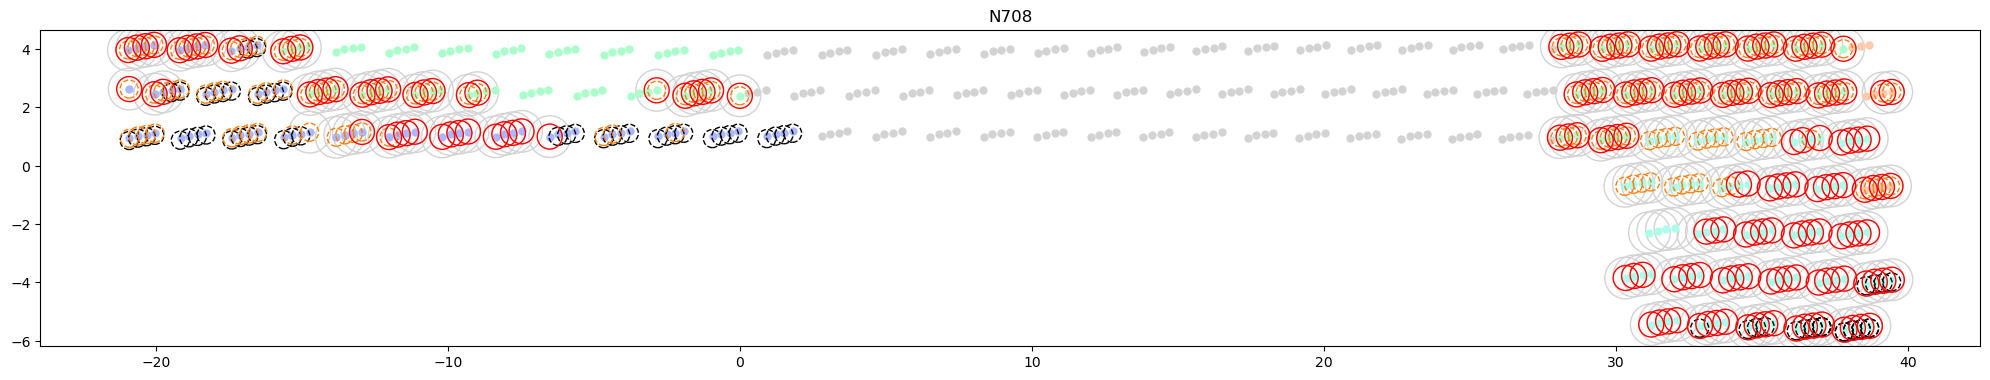

In [111]:
fig = plt.figure(figsize=(20,4))
ax = plt.subplot(111)
ax.set_aspect('equal')

plt.scatter ( wrapRA(hack_cat['RA']), hack_cat['dec'], facecolor='None', edgecolor='lightgrey', s=30**2)
for field in fields.unique():
    cat = ocat.loc[fields==field]
    idx = sigjson_f2022b._field_priorities[field]
    plt.scatter ( wrapRA(cat['RA']), cat['dec'], c=cc_l[idx], s=5**2)
    
plt.scatter ( wrapRA(coo_h.merian_sidecar['racenter']), 
             coo_h.merian_sidecar['deccenter'], facecolor='None', edgecolor='k', s=13**2, ls='--' )

plt.scatter ( wrapRA(ocat.reindex(to_obs.index)['RA']), ocat.reindex(to_obs.index)['dec'], 
             facecolor='None', edgecolor='C1', s=13**2, lw=1, ls='--' )
plt.scatter ( wrapRA(hcat.reindex(inq)['RA']), hcat.reindex(inq)['dec'], 
             facecolor='None', edgecolor='r', s=18**2, lw=1,  )

#plt.scatter ( wrapRA(truly_new_inN708['RA']), truly_new_inN708['dec'], facecolor='None', edgecolor='r', s=18**2, lw=1 )
#plt.scatter ( wrapRA(ocat.reindex(to_obs.index)['RA']), ocat.reindex(to_obs.index)['dec'], color='b', s=1)

plt.title('N708')
plt.tight_layout ()
plt.savefig('/Users/kadofong/Downloads/N708_2022Bprediction.png')

In [512]:
hack_queue = pd.DataFrame(index=hcat.index, columns=['is_queued','qstamp','airmass'])
#hack_queue.loc[truly_new_inN708.index, 'is_queued'] = True
hack_queue.loc[hcat.loc[np.in1d(hcat['object'], coo_h.merian_sidecar['object'])].index, 'is_queued'] = True
hack_queue.loc[truly_new_inN708.index, 'is_queued'] = True

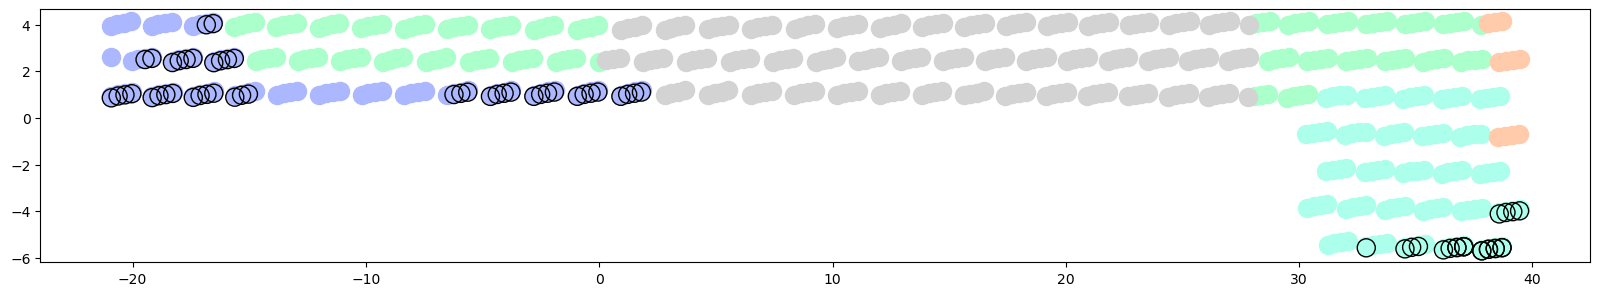

In [514]:
fig = plt.figure(figsize=(20,4))
ax = plt.subplot(111)
ax.set_aspect('equal')

for field in fields.unique():
    cat = ocat.loc[fields==field]
    idx = sigjson_f2022b.priorities[field]
    plt.scatter ( wrapRA(cat['RA']), cat['dec'], c=cc_l[idx], s=13**2)
    
plt.scatter ( wrapRA(ocat.reindex(grp.index)['RA']), ocat.reindex(grp.index)['dec'], facecolor='None', edgecolor=cc, s=18**2, lw=1 )
plt.scatter ( wrapRA(coo_h.merian_sidecar['racenter']), coo_h.merian_sidecar['deccenter'], facecolor='None', edgecolor='k', s=13**2 )
hq = hack_queue.reindex ( coo_h.merian_sidecar
plt.scatter ( wrapRA(hcat.reindex(

In [ ]:
is_queued = None
for idx in range(len(halpha_nights)):
    night = halpha_nights[idx]
    is_queued = sigjson_f2022b.plan_tomorrow( night[2], night[1], night[0], tele_fname, copilot_fname, mfilt='N708', is_queued=is_queued, pad_last_hour=False, maxairmass=1.8, save=False, verbose=False)
to_obs = is_queued.loc[~is_queued['qstamp'].isna()]

In [229]:
#night = obsdates[4]
#newq = sigjson_f2022b.plan_tomorrow( night[2], night[1], night[0], tele_fname, copilot_fname, mfilt='N540', is_queued=is_queued, pad_last_hour=False, maxairmass=1.6, save=False)
    

In [506]:
5 - (5.*10./15.)

1.6666666666666665

In [199]:
coo_o.merian_sidecar.loc[coo_o.merian_sidecar['racenter'] > 300., 'racenter'].min()

340.8357782548524

In [202]:
coo_h.merian_sidecar.loc[coo_h.merian_sidecar['racenter'] > 300., 'racenter'].min()

339.08456994156114